# Tests vs FPs vs FNs

In this notebook we plot the resulting combinations of Tests, FPs and FNs for various combinations of lambdas.

In [1]:
import os
os.chdir("../")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import scipy
import seaborn as sns
import glob
import json
from src import utils
from src.utils import get_fig_dim
from IPython.display import clear_output
import matplotlib.pyplot as plt


sns.set_theme(context='paper', style='ticks', font_scale=1)

In [3]:
name="lambdas"
se=0.95
sp=0.95
width_pt = 469
palette = sns.color_palette('husl', 5)
type_dict = {
    'N' : int, 
    'false_negatives' : int,
    'false_positives' : int,
    'k' : float,
    'lambda_1' : float,
    'lambda_2' : float,
    'method' : str,
    'num_of_infected' : int,
    'num_of_tests' : int,
    # 'avg_group_size' : float,
    'r' : float,
    'score' : float,
    'se' : float,
    'sp' : float,
    'seed' : int
}

In [4]:
files = glob.glob("./outputs/{name}_*_se_{se}_sp_{sp}_*.json".format(name=name, se=str(se), sp=str(sp)))

dicts = []
for fl_id, fl in enumerate(files):
    clear_output(wait=True)
    print('Reading file ' + str(fl_id+1)+'/'+str(len(files)))
    with open(fl,"r") as f:
        js = json.load(f)
        sizes = []
        for group_id in js['groups']:
            sizes.append(int(js['groups'][group_id]))

        avg_group_size = np.mean(sizes)
        
        for seed in js['seeds']:
            seed_js = js.copy()
            seed_js.pop('seeds', None)
            seed_js.pop('groups', None)    
            seed_js = seed_js | js['seeds'][seed]
            seed_js['seed']=seed
            seed_js['avg_group_size'] = avg_group_size

            dicts.append(seed_js)

input_df = pd.DataFrame(dicts)

Reading file 202/202


In [5]:
total_df = input_df.astype(type_dict) # Fix types
total_df = total_df.rename(columns={"method": "Method", "score": "Score", "false_negatives": "FNs", "false_positives": "FPs",
                                    "num_of_tests": "Number of tests", "lambda_1" : "lambda 1", "lambda_2" : "lambda 2",
                                    "exp_tests" : "Expected tests"}) # Rename columns
total_df = total_df.replace({'binomial': 'Dorfman', 'negbin': 'Neg.Bin.'}) # Rename methods
total_df['False Negative rate'] = total_df['FNs']/total_df['num_of_infected']*100
total_df['False Negative rate'] = total_df['False Negative rate'].replace(np.inf, np.nan).fillna(0)
total_df['False Positive rate'] = total_df['FPs']/(total_df['N']-total_df['num_of_infected'])*100
total_df['False Positive rate'] = total_df['False Positive rate'].replace(np.inf, np.nan).fillna(0)
# total_df['Average group size'] = total_df['groups'].apply(lambda dic: np.mean([int(dic[key]) for key in dic]))

In [6]:
FN_df=total_df[total_df['lambda 2']==0.0]
FP_df=total_df[total_df['lambda 1']==0.0]

In [7]:
# print(FP_df[FP_df['lambda 2']==10.0]['FPs'].mean())
# print(FP_df[FP_df['lambda 2']==10.0]['avg_group_size'].mean())
# # FP_df

In [8]:
FN_df = FN_df.groupby(by=['avg_group_size']).mean().reset_index()[['avg_group_size', 'Number of tests', 'False Negative rate', 'False Positive rate', 'FNs', 'FPs']]
FN_df

,avg_group_size,Number of tests,False Negative rate,False Positive rate,FNs,FPs
0,1.000000,100.000000,1.380549,5.004548,0.123120,4.88121
1,16.666667,24.720463,2.720331,0.920052,0.241577,0.81990


In [9]:
FP_df = FP_df.groupby(by=['avg_group_size']).mean().reset_index()[['avg_group_size', 'Number of tests', 'False Negative rate', 'False Positive rate', 'FNs', 'FPs']]
FP_df

,avg_group_size,Number of tests,False Negative rate,False Positive rate,FNs,FPs
0,2.000000,58.846920,2.718124,0.361118,0.241980,0.325920
1,2.941176,44.121589,2.708943,0.443098,0.239475,0.391069
2,3.030303,43.214193,2.721821,0.447415,0.241079,0.395236
3,4.000000,36.272680,2.692444,0.509874,0.238050,0.446280
4,5.000000,32.239600,2.715704,0.566526,0.239630,0.495550
5,5.882353,30.011280,2.759397,0.607950,0.241310,0.532810
6,6.250000,29.317430,2.727746,0.627312,0.241980,0.550070
7,6.666667,28.637610,2.706226,0.644873,0.240940,0.566590
8,7.142857,27.973690,2.688860,0.666819,0.240113,0.584920
9,7.692308,27.338370,2.719229,0.684736,0.241560,0.600960


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


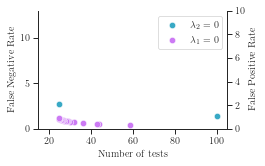

In [10]:
utils.latexify(font_size=10, legend_font_size=10)

fig_height, fig_aspect = get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_height*fig_aspect,fig_height))

marker_size = 40
p = sns.scatterplot(data=FN_df, x="Number of tests", y="False Negative rate", ax=ax, color=palette[3], s=marker_size, label=r'$\lambda_2 = 0$')
# sns.pointplot(data=FN_df, x='Number of tests', y='False Negative rate', ax=ax, color=palette[3], join=False)
# print(ax.get_xlim(), ax.get_ylim())
ax2 = ax.twinx()
p2 = sns.scatterplot(data=FP_df, x="Number of tests", y="False Positive rate", ax=ax2, color=palette[4], s=marker_size, label=r'$\lambda_1 = 0$')
# sns.pointplot(data=FP_df, x='Number of tests', y='False Positive rate', ax=ax2, color=palette[4])
# ax.set_xlim([0.0,101.0])
# ax.set_ylim([1.0,3.0])
# ax2.set_xlim([0,100])
sns.despine(top=True, right=False)

# ax.legend(handles=[p, p2], labels=['Minimizing FNR', 'Minimizing FPR'])

# ax.legend(loc='upper right')
# ax2.legend(loc='lower right')
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.get_legend().remove()
ax2.get_legend().remove()
# print(handles, handles2)
ax2.legend(handles+handles2, labels + labels2, loc='upper right')

# # # fig.legend((l1, l2), ('FNR', 'FPR'))
# ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
# ax2.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
# ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.1f'))

# ax.set_xticks([30,100])
# ax.set_xticklabels([30,100])
# ax.set_xlim([0,101])

# ax.set_ylim([1,3])

ax.set_xlim([15,105])
ax.set_ylim([0,13])
ax2.set_ylim([0,10])
# if se == 0.95 and sp ==0.95:
#     ax.set_ylim([1,2.9])
#     ax2.set_ylim([0.3,1.2])
# elif se==0.75 and sp==0.75:
#     print()
    # ax.set_ylim([1,2.9])
    # ax2.set_ylim([6,9])
    
ax.set_xlabel('Number of tests')
ax.set_ylabel('False Negative Rate')
ax2.set_ylabel('False Positive Rate')
fig.tight_layout()
fig.savefig('figures/{name}_se_{se}_sp_{sp}.pdf'.format(name=name, se=se, sp=sp))